In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import catboost as cat_
import xgboost as xgb
import seaborn as sns
import lightgbm as lgb

In [2]:
!pip install catboost

     |████████████████████████████████| 66.1MB 44kB/s 


In [4]:
from google.colab import files
uploaded = files.upload()

Saving Test.csv to Test.csv
Saving Train.csv to Train.csv


In [5]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [6]:
print(train.shape)
print(test.shape)

(56000, 52)
(24000, 51)


**Helper Function**

In [7]:
class func() :   
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state
        
        assert self.model_type in ('catboost', 'xgboost', 'lgbm'), 'Incorrect model_type'
    def __call__(self, plot = True):
        return self.fit(plot)

    def fit(self, plot):
        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=500,
                           verbose=50,use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:,1]
            x_train_predict = self.model.predict_proba(X_train)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:,1]
            return x_test_predict, x_train_predict

        def xgboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            x_train_predict = self.model.predict_proba(X_train, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            return x_test_predict, x_train_predict

        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, num_iteration = self.model.best_iteration_)[:,1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration = self.model.best_iteration_)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration = self.model.best_iteration_)[:,1]
            return x_test_predict, x_train_predict


        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 10 # number of folds
        kf = StratifiedKFold(n_splits = splits)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train,X_test = self.train.iloc[train_index],self.train.iloc[test_index]
            y_train,y_test = self.label.iloc[train_index],self.label.iloc[test_index]

            print(f"================================Fold{fold_count+1}====================================")
            if self.model_type == 'catboost': x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'xgboost': x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm': x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)

            print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_test, x_test_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))

        if plot:
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_,self.train.columns)), columns=['Value','Feature'])
            plt.figure(figsize=(30,25))
            sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.ylabel('Feature Importance Score')
            plt.show()
        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p/splits, self.model

In [10]:
ntrain = train.shape[0]
ntest = test.shape[0]
combine = pd.concat((train, test)).reset_index(drop=True)

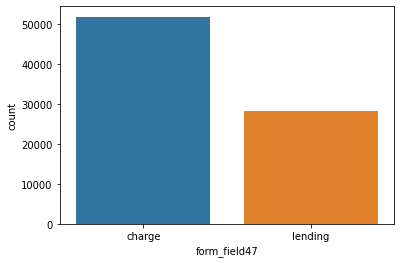

In [12]:
# categorical variable
sns.countplot(x='form_field47', data=combine)

In [13]:
# label encoding
combine['form_field47']  = pd.factorize(combine['form_field47'])[0]

In [14]:
test_id = pd.read_csv('Test.csv')
identifier = test_id['Applicant_ID']
#identifier

In [15]:
combine.drop('Applicant_ID', axis=1, inplace=True)
combine.shape

(80000, 51)

In [17]:
combine['form_field19_20'] = (combine['form_field19'] + combine['form_field20'])/2

In [16]:
# Find percent of missing variables
for a in combine.columns:
    print(a + " missing: " + str(int(100 - (combine[a].count()/len(combine)*100))) + "%")

form_field1 missing: 4%
form_field2 missing: 6%
form_field3 missing: 0%
form_field4 missing: 0%
form_field5 missing: 0%
form_field6 missing: 23%
form_field7 missing: 9%
form_field8 missing: 23%
form_field9 missing: 14%
form_field10 missing: 0%
form_field11 missing: 56%
form_field12 missing: 17%
form_field13 missing: 10%
form_field14 missing: 0%
form_field15 missing: 40%
form_field16 missing: 23%
form_field17 missing: 19%
form_field18 missing: 18%
form_field19 missing: 0%
form_field20 missing: 0%
form_field21 missing: 28%
form_field22 missing: 36%
form_field23 missing: 50%
form_field24 missing: 23%
form_field25 missing: 9%
form_field26 missing: 13%
form_field27 missing: 16%
form_field28 missing: 0%
form_field29 missing: 0%
form_field30 missing: 45%
form_field31 missing: 70%
form_field32 missing: 9%
form_field33 missing: 2%
form_field34 missing: 0%
form_field35 missing: 41%
form_field36 missing: 3%
form_field37 missing: 9%
form_field38 missing: 0%
form_field39 missing: 7%
form_field40 mi

In [17]:
# They are all numerical features right now
missing_col = combine.columns[combine.isna().any()]
missing_col

Index(['form_field1', 'form_field2', 'form_field3', 'form_field4',
       'form_field5', 'form_field6', 'form_field7', 'form_field8',
       'form_field9', 'form_field10', 'form_field11', 'form_field12',
       'form_field13', 'form_field15', 'form_field16', 'form_field17',
       'form_field18', 'form_field19', 'form_field20', 'form_field21',
       'form_field22', 'form_field23', 'form_field24', 'form_field25',
       'form_field26', 'form_field27', 'form_field28', 'form_field29',
       'form_field30', 'form_field31', 'form_field32', 'form_field33',
       'form_field34', 'form_field35', 'form_field36', 'form_field37',
       'form_field38', 'form_field39', 'form_field40', 'form_field41',
       'form_field42', 'form_field43', 'form_field44', 'form_field45',
       'form_field46', 'form_field48', 'form_field49', 'form_field50',
       'default_status'],
      dtype='object')

In [18]:
for col in missing_col:
    combine[col].fillna(-999, inplace = True)

In [19]:
combine.head()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status
0,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,11333126.0,4397256.0,2301324.0,7875694.0,96375139,112181765.0,1.0,1.0,1.0,3.0,3.0,134.655,-999.00,-999.00,134.655,4000.5,17064.0,11376.0,60.0,17064.0,5962.0,-999.0,1052.0,8.0000,2.0,-999.0,12.0,12.0,4.0,0.0,-999.0000,-999.0,0.392854,2.02,0.711632,0.0,0.0,0,-999.000000,1.129518,0.044335,no
1,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,2533168.0,244292.0,3982971.0,2141445.0,28141427,45169902.0,1.0,1.0,1.0,2.0,2.0,109.230,11385.24,14584.29,86.685,4161.0,13413.0,8942.0,304.0,13413.0,5780.0,-999.0,2554.0,17.5000,0.0,0.0,16.0,24.0,8.0,0.0,-999.0000,-999.0,0.314281,8.08,0.183584,-999.0,0.0,0,349.805730,1.620483,0.322436,no
2,3276.0,0.53845,3.1510,0.0,6.282,-999.0,956940.0,-999.0,192944.0,1079864.0,-999.0,-999.0,0.0,16576457,22452691.0,-999.0,-999.0,-999.0,0.0,0.0,-999.000,-999.00,-999.00,-999.000,1597.5,4746.0,3164.0,60.0,15696.0,-999.0,14508.0,70.0,0.6666,0.0,-999.0,12.0,0.0,6.0,0.0,149.6805,-999.0,0.162965,18.18,0.791136,0.0,0.0,0,-999.000000,1.513370,0.011640,yes
3,3372.0,0.17005,0.5050,0.0,0.000,192166.0,3044703.0,385499.0,3986472.0,3621979.0,-999.0,771776.0,1186839.0,48187375,136297820.0,0.0,0.0,0.0,1.0,1.0,120.120,8580.00,0.00,85.800,1701.0,4014.0,2676.0,60.0,11679.0,-999.0,-999.0,522.0,7.8334,1.0,1.0,4.0,8.0,4.0,1.0,-999.0000,-999.0,0.488884,2.02,0.685168,-999.0,0.0,0,89.940100,0.664452,0.082729,no
4,3370.0,0.77270,1.1010,0.0,0.000,1556.0,214728.0,214728.0,1284089.0,361770.0,396391.0,818456.0,511535.0,28141427,15292757.0,0.0,0.0,0.0,3.0,3.0,104.535,8360.19,10326.45,115.335,1551.0,3285.0,2190.0,60.0,19437.0,12958.0,5202.0,272.0,1.0000,0.0,0.0,24.0,2.0,24.0,0.0,150.0135,-999.0,0.275000,12.12,0.438168,0.0,0.0,0,97.887502,1.427891,0.045630,no


In [22]:
combine['form_field7_8'] = (combine['form_field7'] + combine['form_field8'])/2

In [20]:
# label encoding 0-no, 1-yes
combine['default_status']  = pd.factorize(combine['default_status'])[0]

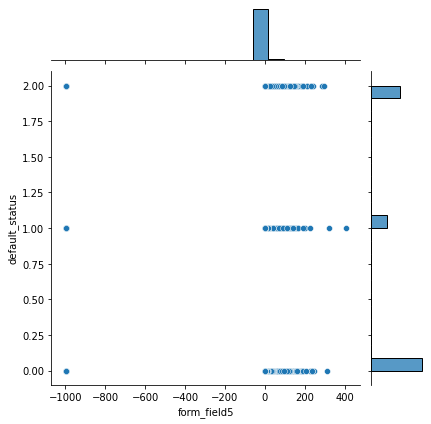

In [21]:
sns.jointplot(x='form_field5', y='default_status', data=combine)

There are prescence of outliers in the above plot. Let's visualize with boxplot

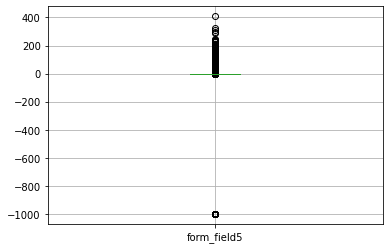

In [22]:
figure=combine.boxplot(column='form_field5')

In [23]:
combine.describe()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,8.000000e+04,80000.000000,8.000000e+04,80000.000000
mean,3287.660438,-68.828645,-5.206661,-5.407457,-4.244421,4.766124e+05,6.212049e+06,2.010109e+06,1.137233e+07,1.178709e+07,9.133091e+05,2.283522e+06,5.375417e+06,7.627971e+07,6.854210e+07,-230.965625,-197.663387,-184.231063,0.895700,-5.246925,-219.491637,3856.34137,2706.827898,-155.868411,2276.006719,8634.383813,5005.644737,17291.208650,16405.449675,2391.082162,2532.531562,754.004575,-8.178773,-6.040075,-412.145962,-23.819175,-88.544975,2.250325,-75.340537,-748.966330,-647.176954,-23.378842,-3.664142,-96.206084,-560.095738,-284.508888,0.352000,1.904294e+05,-5.209257,4.992329e+05,0.771437
std,953.845184,254.043467,78.922164,78.942587,79.698500,1.286277e+06,1.756015e+07,3.619186e+06,1.977782e+07,2.606690e+07,3.582952e+06,4.325686e+06,2.114869e+07,3.068579e+09,1.062530e+08,421.390460,398.259566,387.723725,7.278436,78.988556,490.627246,5827.72901,5532.150468,612.097081,2147.395817,9014.634489,5602.403076,26952.721836,9736.309261,3864.658587,6363.369262,1149.473771,148.988675,78.908575,491.923781,189.346607,297.385324,79.956096,263.958178,473.967997,515.916835,152.213723,101.364842,295.575330,495.845301,450.943884,0.477597,1.367996e+06,78.913111,5.437960e+06,0.881097
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,0.000000e+00,-9.990000e+02,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.00000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,-9.990000e+02,-999.000000,-9.990000e+02,0.000000
25%,3336.000000,0.047550,0.000000,0.000000,0.000000,0.000000e+00,3.189800e+05,0.000000e+00,4.240100e+05,4.076720e+05,-9.990000e+02,1.400400e+04,0.000000e+00,1.657646e+07,-9.990000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,-999.000000,-999.00000,-999.000000,0.000000,897.000000,1734.000000,730.000000,60.000000,9672.000000,-999.000000,-999.000000,112.000000,2.166600,0.000000,-999.000000,6.000000,0.000000,4.000000,0.000000,-999.000000,-999.000000,0.000000,2.020000,0.349528,-999.000000,-999.000000,0.000000,-9.990000e+02,0.000000,7.259387e-03,0.000000
50%,3472.000000,0.227125,0.057800,0.000000,0.000000,4.045600e+04,2.176066e+06,3.718840e+05,3.700946e+06,3.626647e+06,-9.990000e+02,6.970880e+05,1.148717e+06,2.814143e+07,3.854990e+07,0.000000,0.000000,0.000000,0.000000,0.000000,51.127500,601.71750,-999.000000,30.030000,1995.000000,6570.000000,3528.0000

For features with outliers, majority occurs around the 25th percentile to the 75th percentile such as form_field4, form_field5, form_field16, form_field17, form_field18, form_field19, form_field20...

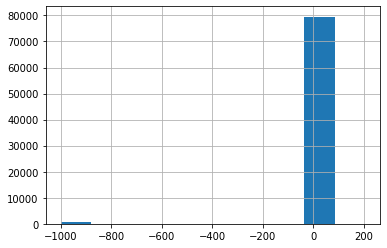

In [24]:
combine.form_field4.hist()

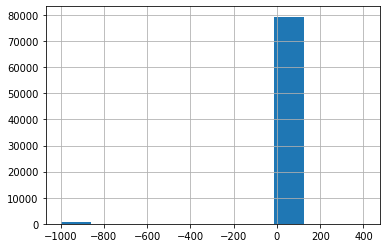

In [25]:
combine.form_field5.hist()

In [35]:
# let's try to create some more features
combine['form_field7_8_9'] = (combine['form_field7'] + combine['form_field8'] + combine['form_field9'])/3
combine['form_field7*8'] = (combine['form_field7'] * combine['form_field8'])
combine['form_field8*9'] = (combine['form_field8'] * combine['form_field9'])
combine['form_field9*10'] = (combine['form_field9'] * combine['form_field10'])

In [70]:
features = combine.columns
features

Index(['form_field1', 'form_field2', 'form_field4', 'form_field5',
       'form_field6', 'form_field7', 'form_field8', 'form_field9',
       'form_field10', 'form_field11', 'form_field12', 'form_field13',
       'form_field14', 'form_field15', 'form_field16', 'form_field17',
       'form_field19', 'form_field20', 'form_field21', 'form_field22',
       'form_field23', 'form_field24', 'form_field25', 'form_field26',
       'form_field27', 'form_field28', 'form_field29', 'form_field30',
       'form_field31', 'form_field32', 'form_field33', 'form_field34',
       'form_field35', 'form_field36', 'form_field37', 'form_field38',
       'form_field39', 'form_field40', 'form_field41', 'form_field42',
       'form_field43', 'form_field44', 'form_field45', 'form_field46',
       'form_field47', 'form_field48', 'form_field50', 'default_status',
       'form_field19_20', 'form_field7_8_9_10', 'form_field7*8',
       'form_field8*9', 'form_field9*10'],
      dtype='object')

**VIF**

In [71]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = combine[features.drop('default_status')]

# we create a new data frame which will include all the VIFs
# each variable has its own variance inflation factor as this measure is variable specific (not model specific)
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = variables.columns

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [72]:
vif.sort_values(by='VIF', ascending=True)

,VIF,Features
12,1.000982,form_field14
30,1.030976,form_field33
0,1.031990,form_field1
16,1.034653,form_field19
46,1.062949,form_field50
13,1.086045,form_field15
44,1.088368,form_field47
45,1.100759,form_field48
1,1.118059,form_field2
9,1.134040,form_field11


In [53]:
# There is need to drop one of the features with the highest VIF,
# this will in turn result in a lower VIF for some other features
# Feature 'form_field7_8' will be dropped among the 7 features with
# the highest VIF.

combine.drop('form_field7_8', axis=1, inplace=True)

In [54]:
train = combine[:ntrain].copy()
#train.drop_duplicates(inplace = True, ignore_index=True)
target = train.default_status.copy()
train.drop('default_status', axis=1, inplace=True)

test = combine[ntrain:].copy()
test.drop('default_status', axis=1, inplace=True)
test = test.reset_index(drop=True)

**MODEL 1: CATBOOST**

================================Fold1====================================
0:	learn: 0.7974549	test: 0.7914323	best: 0.7914323 (0)	total: 28.1ms	remaining: 4m 40s
50:	learn: 0.8328882	test: 0.8190828	best: 0.8190828 (50)	total: 1.09s	remaining: 3m 33s
100:	learn: 0.8389686	test: 0.8237547	best: 0.8237547 (100)	total: 2s	remaining: 3m 15s
150:	learn: 0.8426026	test: 0.8258365	best: 0.8258365 (150)	total: 2.92s	remaining: 3m 10s
200:	learn: 0.8449838	test: 0.8272208	best: 0.8272208 (200)	total: 3.81s	remaining: 3m 5s
250:	learn: 0.8472634	test: 0.8281600	best: 0.8281600 (250)	total: 4.7s	remaining: 3m 2s
300:	learn: 0.8491582	test: 0.8288255	best: 0.8288255 (300)	total: 5.61s	remaining: 3m
350:	learn: 0.8506992	test: 0.8292671	best: 0.8292791 (342)	total: 6.52s	remaining: 2m 59s
400:	learn: 0.8525230	test: 0.8297622	best: 0.8297622 (400)	total: 7.43s	remaining: 2m 57s
450:	learn: 0.8542091	test: 0.8301635	best: 0.8301635 (450)	total: 8.33s	remaining: 2m 56s
500:	learn: 0.8558990	test: 0.8

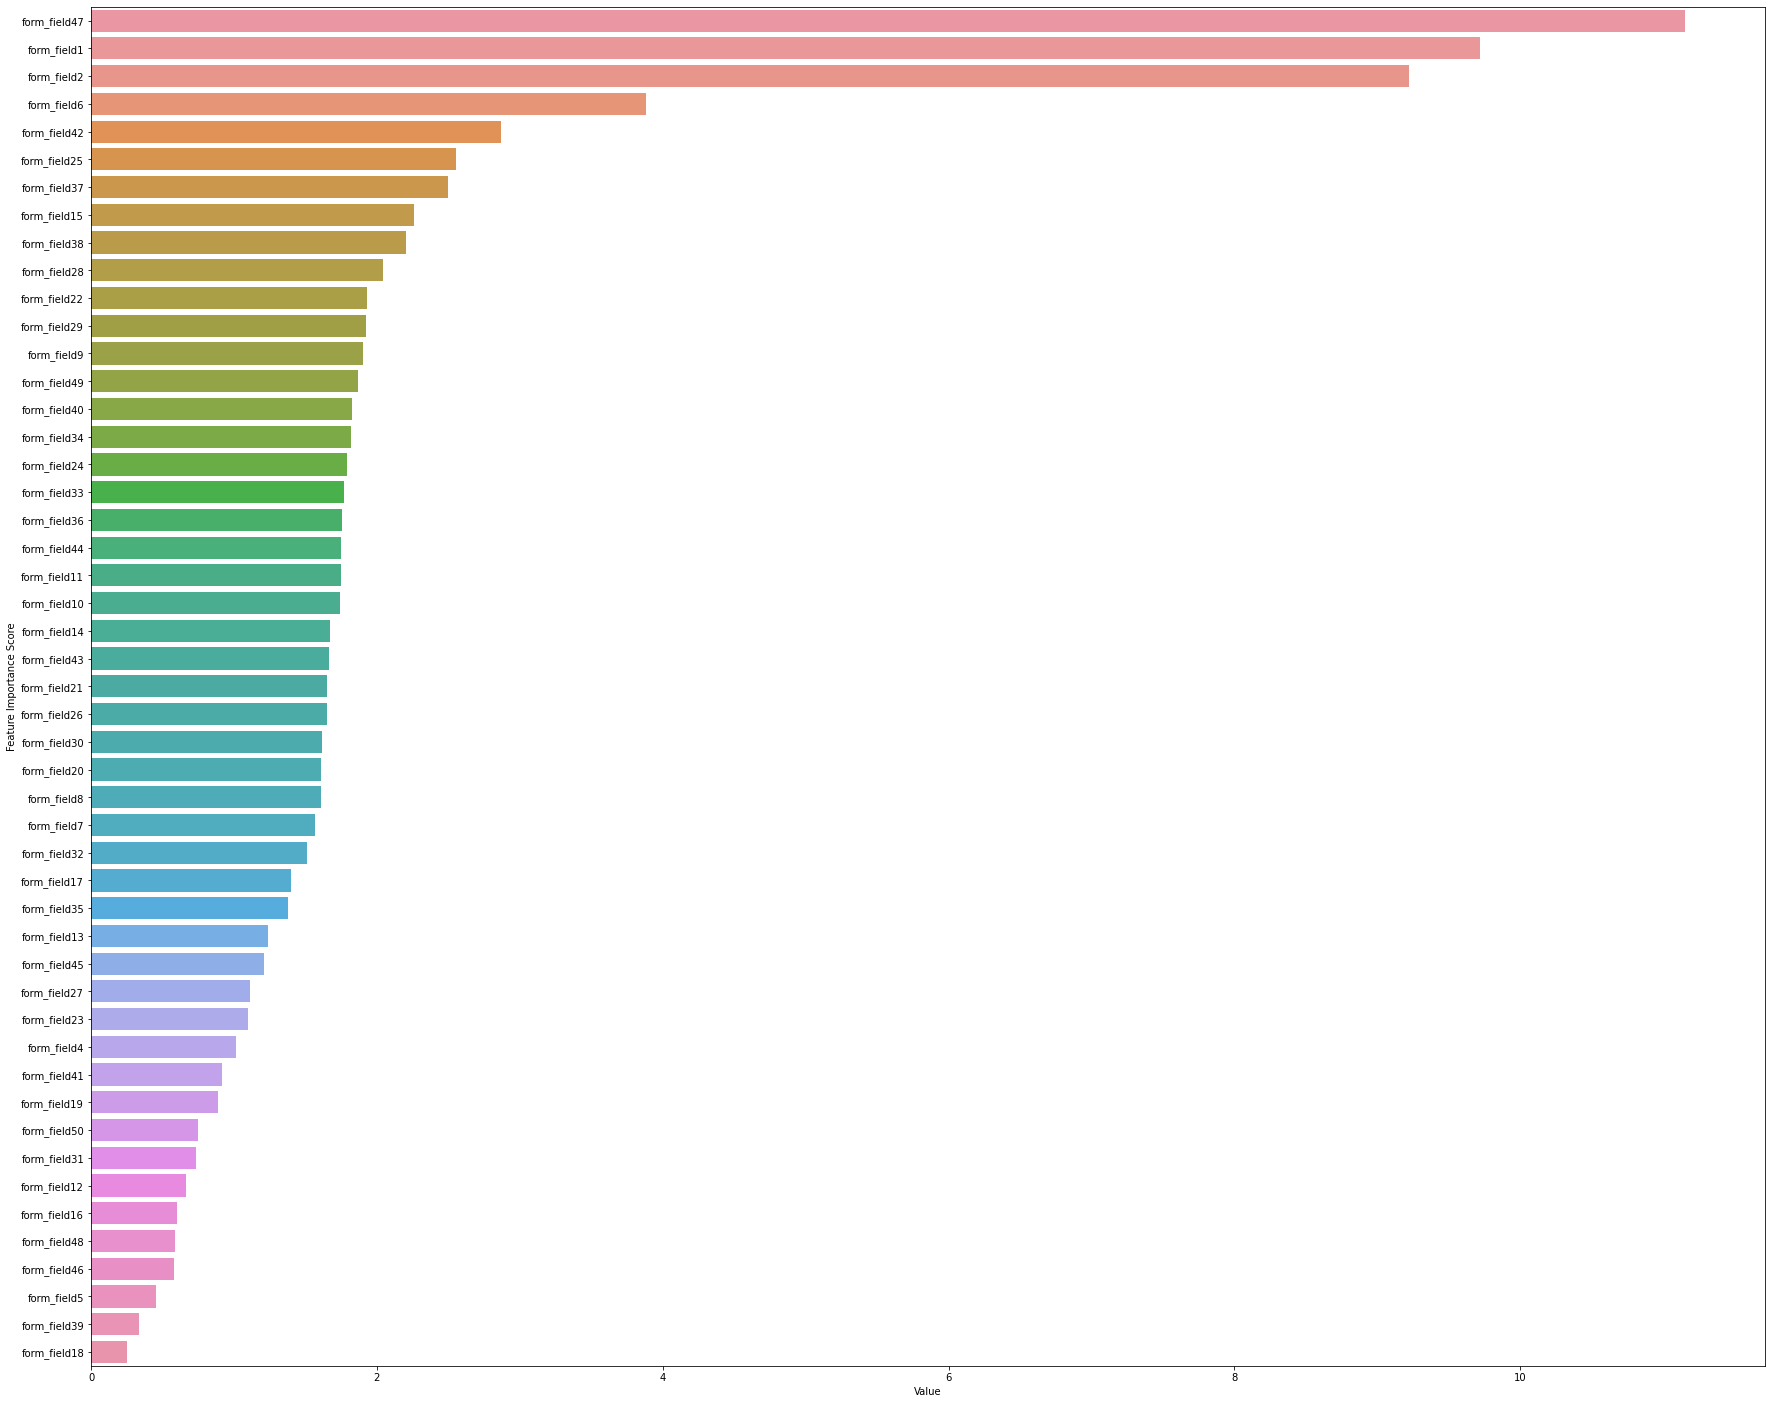

0.8411682069296514 0.879011301408932 0.009344837732283253


In [55]:
catboost = cat_.CatBoostClassifier(n_estimators=10000, max_depth=8, eval_metric='AUC', reg_lambda = 370, task_type="GPU", devices='0:1')

func_= func(train, target, test, catboost, 'catboost', 1000)
val_p1, test_p1, model1 = func_()

**MODEL2: XGB**

================================Fold1====================================
[0]	validation_0-auc:0.720117
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.758159
[2]	validation_0-auc:0.775652
[3]	validation_0-auc:0.780343
[4]	validation_0-auc:0.782676
[5]	validation_0-auc:0.78327
[6]	validation_0-auc:0.785351
[7]	validation_0-auc:0.790948
[8]	validation_0-auc:0.79391
[9]	validation_0-auc:0.79659
[10]	validation_0-auc:0.797972
[11]	validation_0-auc:0.800257
[12]	validation_0-auc:0.802408
[13]	validation_0-auc:0.804677
[14]	validation_0-auc:0.805775
[15]	validation_0-auc:0.806248
[16]	validation_0-auc:0.80848
[17]	validation_0-auc:0.810741
[18]	validation_0-auc:0.811494
[19]	validation_0-auc:0.812124
[20]	validation_0-auc:0.812986
[21]	validation_0-auc:0.813772
[22]	validation_0-auc:0.814601
[23]	validation_0-auc:0.815047
[24]	validation_0-auc:0.816402
[25]	validation_0-auc:0.81712
[26]	validation_0-auc:0.817225
[27]	validation_0-auc:0.818011
[28]	vali

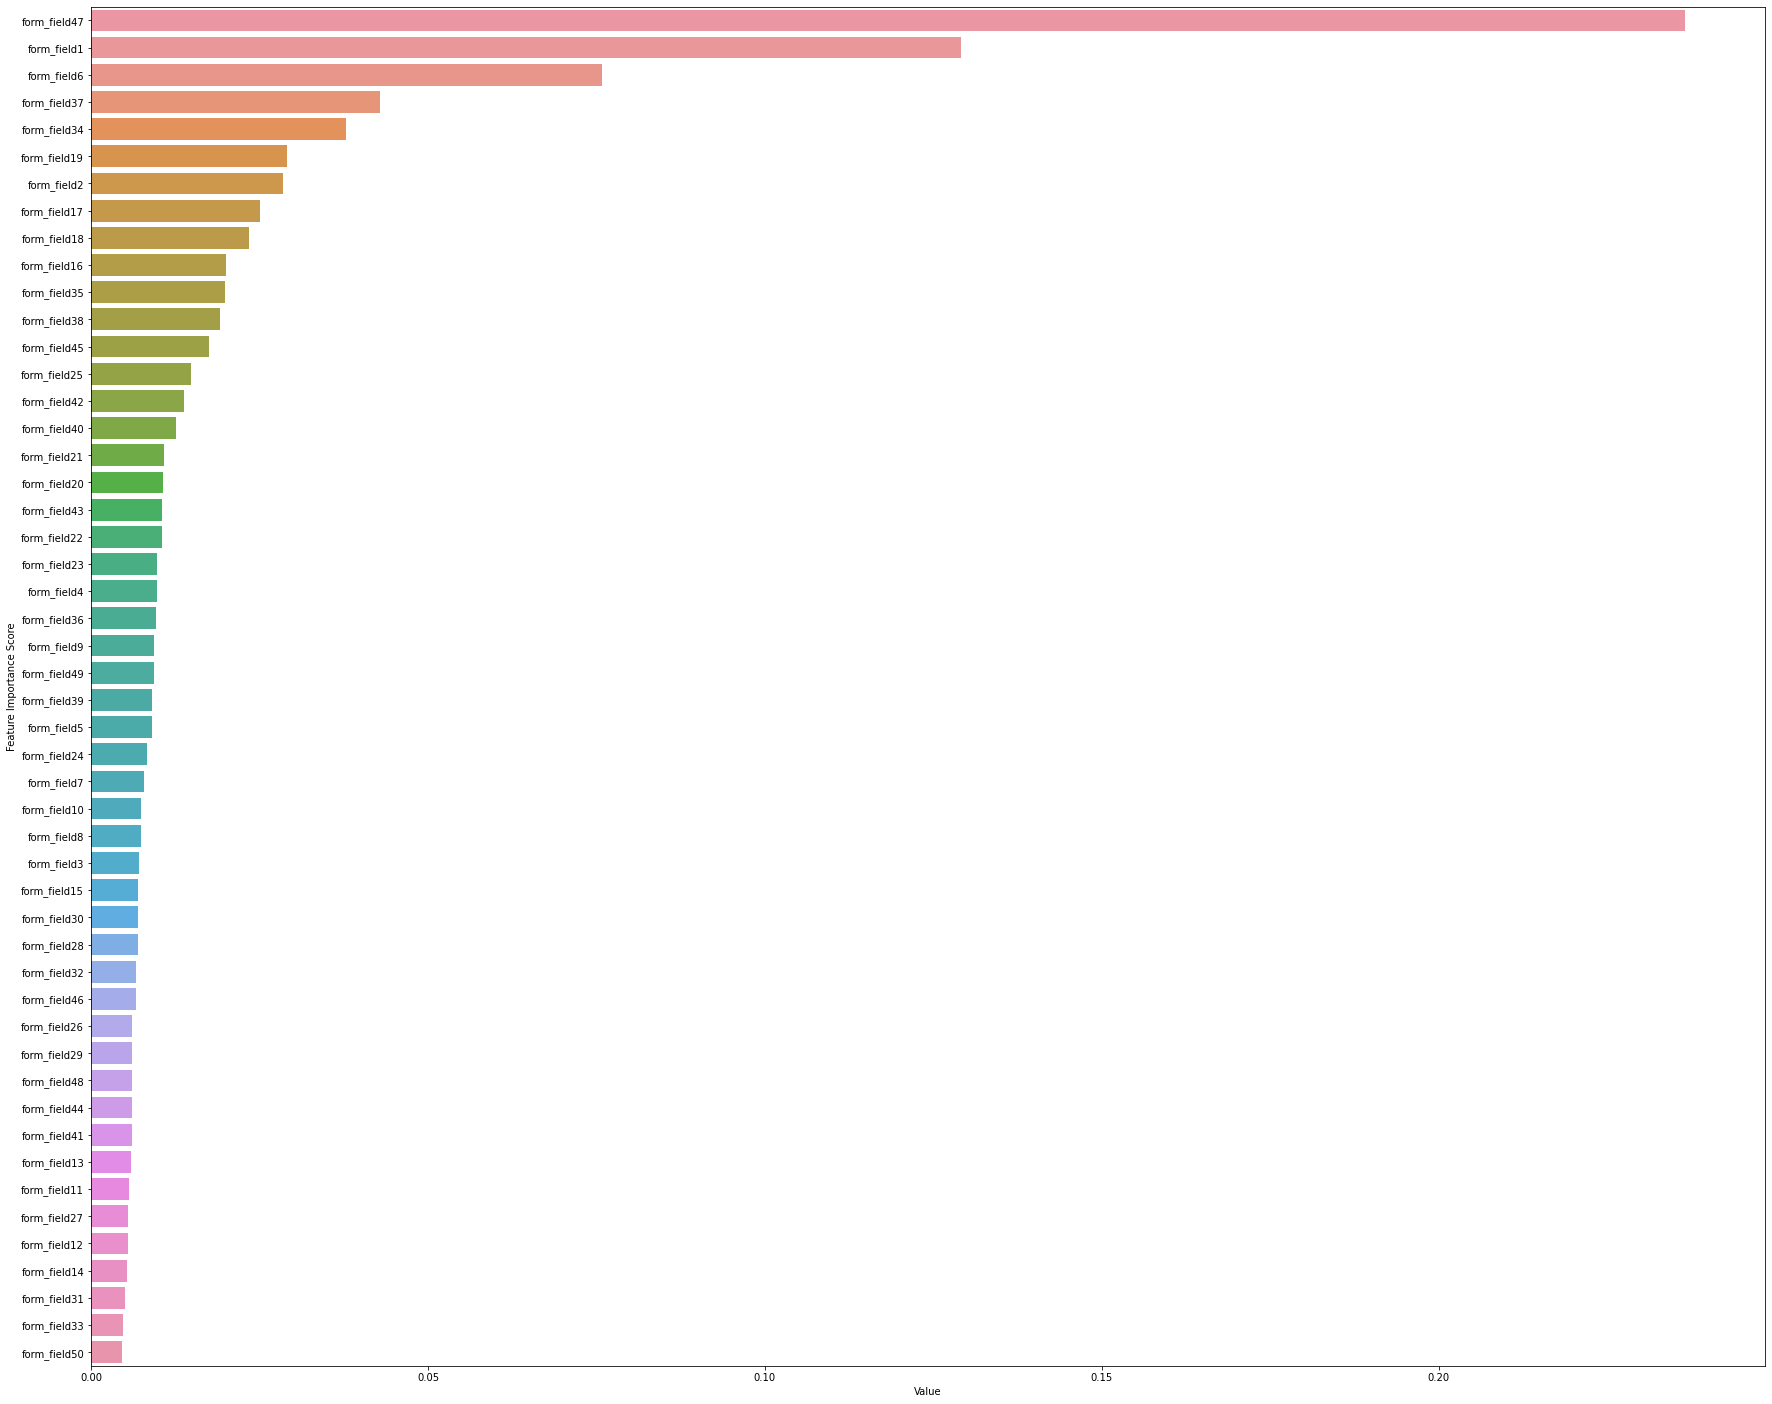

0.8401615696267782 0.8817212907543514 0.009022040270061394


In [37]:
xgboost = xgb.XGBClassifier(objective ='binary:logistic', 
                          eta = 0.99,
                          max_depth = 8, 
                          n_estimators = 5000,
                          reg_lambda = 700,
                          sub_sample = 0.7,
                          colsample_bytree = 0.8, tree_method='gpu_hist', gpu_id=0)

func_= func(train, target, test, xgboost, 'xgboost', 1000)
val_p2, test_p2, model2 = func_()

**MODEL3: LGBM**

================================Fold1====================================
[1]	valid_0's auc: 0.78985
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.794263
[3]	valid_0's auc: 0.79715
[4]	valid_0's auc: 0.801488
[5]	valid_0's auc: 0.804243
[6]	valid_0's auc: 0.806893
[7]	valid_0's auc: 0.808159
[8]	valid_0's auc: 0.810636
[9]	valid_0's auc: 0.812305
[10]	valid_0's auc: 0.814322
[11]	valid_0's auc: 0.815396
[12]	valid_0's auc: 0.815882
[13]	valid_0's auc: 0.816171
[14]	valid_0's auc: 0.81647
[15]	valid_0's auc: 0.816831
[16]	valid_0's auc: 0.817454
[17]	valid_0's auc: 0.817819
[18]	valid_0's auc: 0.818837
[19]	valid_0's auc: 0.819324
[20]	valid_0's auc: 0.81976
[21]	valid_0's auc: 0.820317
[22]	valid_0's auc: 0.82067
[23]	valid_0's auc: 0.82105
[24]	valid_0's auc: 0.821535
[25]	valid_0's auc: 0.82199
[26]	valid_0's auc: 0.82218
[27]	valid_0's auc: 0.822556
[28]	valid_0's auc: 0.822918
[29]	valid_0's auc: 0.823511
[30]	valid_0's auc: 0.823878
[31]	valid_

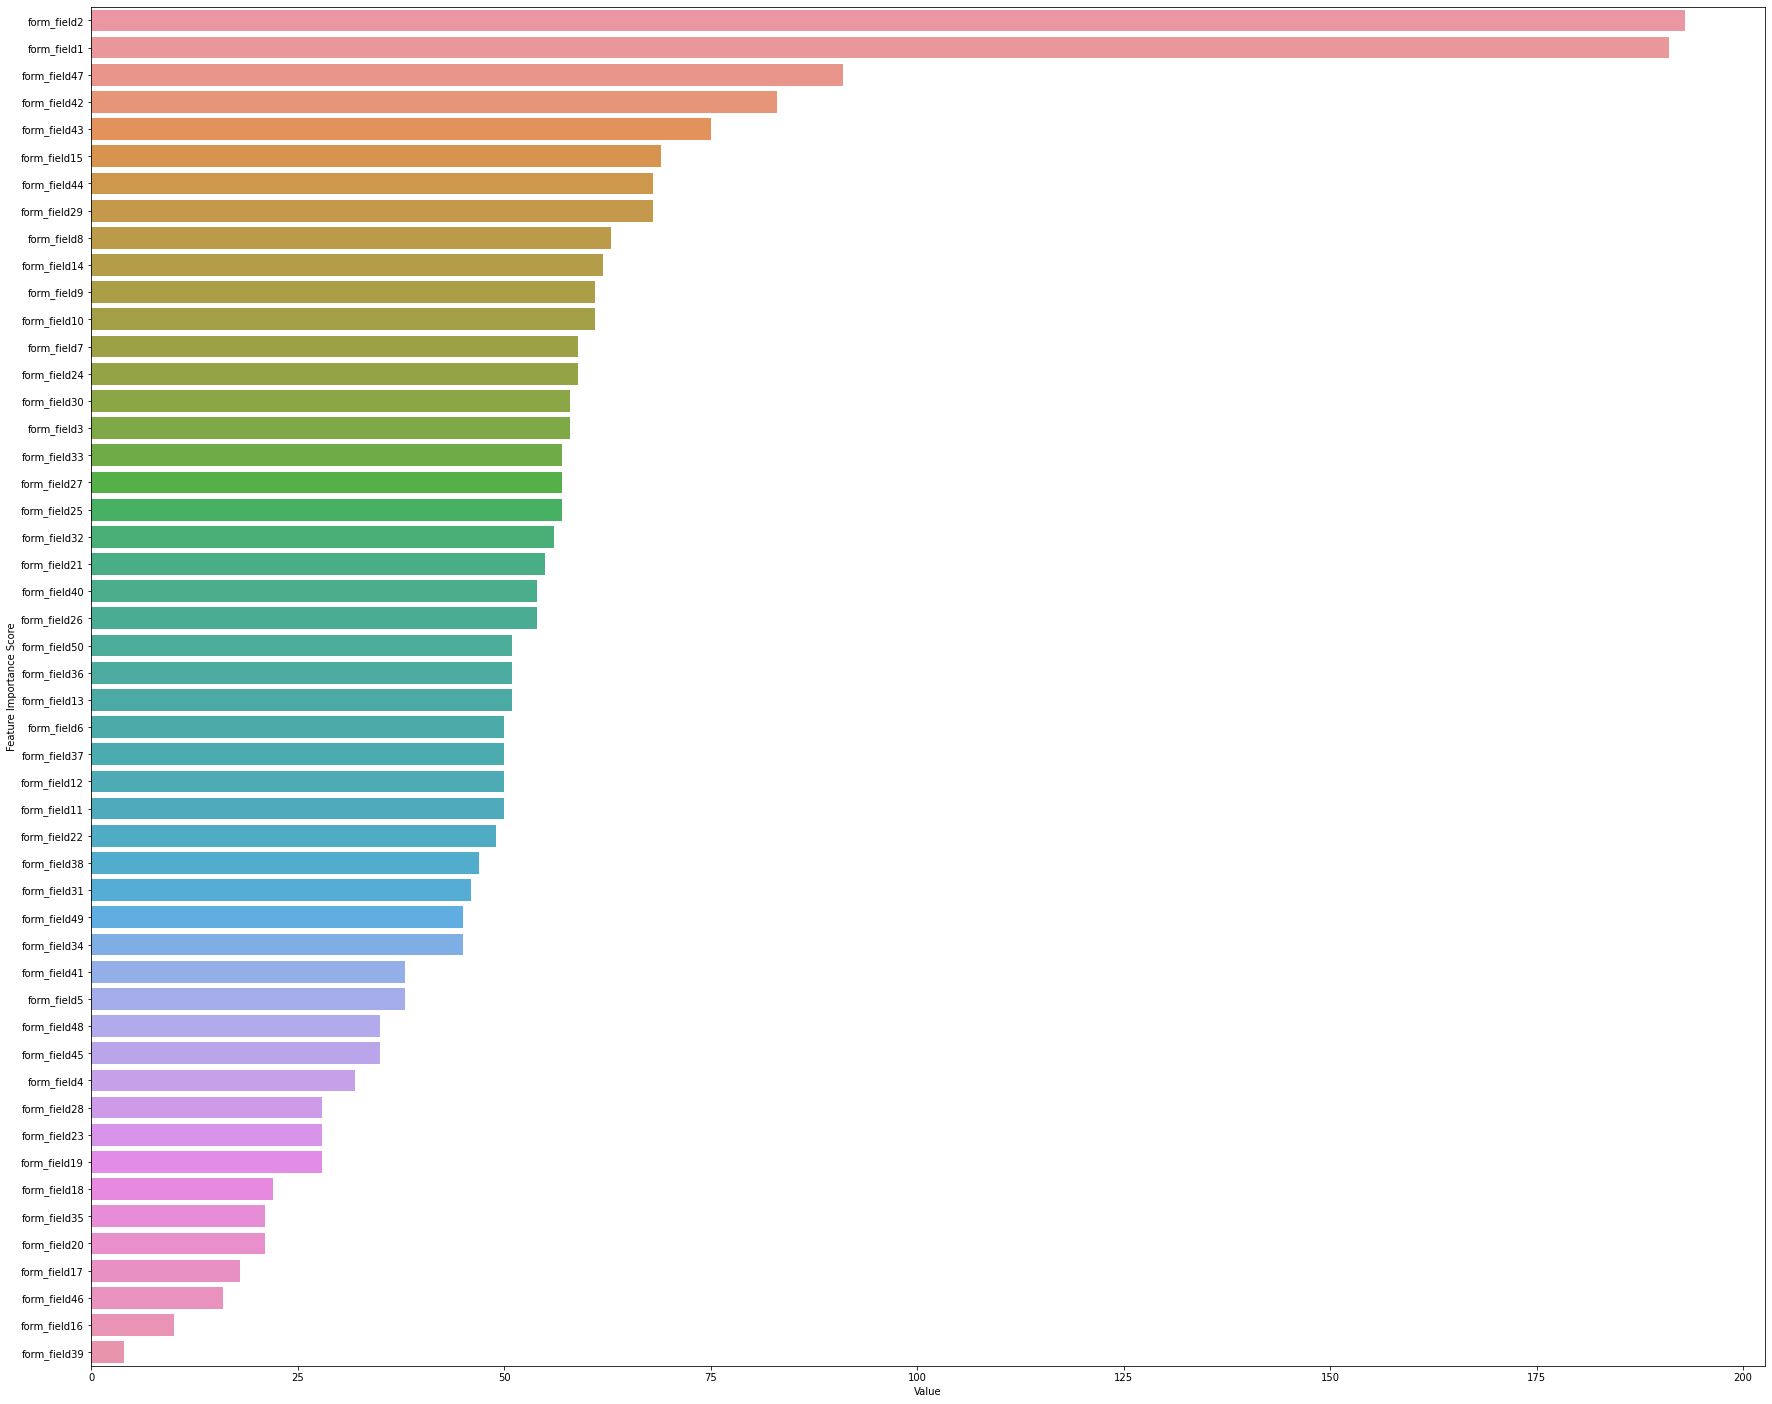

0.8394388006203715 0.8723160054101242 0.00911258001941729


In [49]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(objective =  'binary', 
                            metric= 'auc',
                            boosting_type= 'gbdt',
                            lambda_l1= 0.0004912993970392775,
                            lambda_l2= 9.424350138808432,
                            num_leaves= 24,
                            feature_fraction= 1.0,
                            bagging_fraction= 0.9540416539312312,
                            bagging_freq= 10,
                            min_child_samples= 50, n_estimators = 2000)

func_= func(train, target, test, lgb_model, 'lgbm', 1000)
val_p3, test_p3, model3 = func_()

**COLLINEARITY**

In [53]:
corr_matrix = combine[features].corr()
corr_matrix

,form_field1,form_field2,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status,form_field19_20,form_field7_8_9_10,form_field7_8_9,form_field7*8,form_field8*9,form_field9*10
form_field1,1.000000,0.060557,0.356238,0.351845,0.154465,0.128431,0.231145,0.221636,0.176213,-0.088561,0.149360,0.098069,-0.018947,0.090311,0.432699,0.458121,0.460386,0.051184,0.358759,0.371179,0.107772,0.081761,0.319603,0.333185,0.302146,0.303518,0.156828,0.291482,0.173528,0.082384,0.356009,0.099728,0.357218,0.241410,0.291247,0.493555,0.361365,0.620374,0.079363,0.150117,0.415145,0.380334,0.579207,0.239817,0.281484,0.093901,0.051833,0.357921,0.040838,-0.049935,0.358666,0.213616,0.228360,0.058730,0.133501,0.042192
form_field2,0.060557,1.000000,0.076094,0.075762,-0.137203,-0.037638,-0.093882,-0.027697,-0.031523,0.012457,0.019271,-0.015148,-0.004447,-0.007318,0.048423,0.049037,0.049554,0.028717,0.077016,0.064841,0.164658,0.144470,0.048844,-0.145937,-0.097103,-0.092440,-0.121260,-0.097449,0.053418,0.040235,-0.035991,-0.000681,0.075294,0.205466,0.090362,0.057654,0.093329,0.075593,0.054472,0.113324,0.074360,0.077124,0.085522,-0.023469,0.099346,-0.095534,-0.004690,0.076170,0.024989,0.020888,0.076999,-0.041953,-0.047305,-0.022298,-0.028264,-0.001257
form_field4,0.356238,0.076094,1.000000,0.990528,0.026167,0.026026,0.038961,0.040653,0.032827,0.024198,0.038120,0.017899,-0.018763,0.011733,0.137518,0.152586,0.159584,0.096374,0.997882,0.120244,0.065126,0.052266,0.104911,0.117410,0.080708,0.080900,0.046903,0.139413,0.073592,0.046547,0.116347,0.137914,0.998164,0.090953,0.410188,0.240337,0.993538,0.275235,0.044792,0.054836,0.484704,0.778955,0.239996,0.067218,0.132378,0.009841,0.009823,0.998885,0.006412,0.004825,0.997892,0.039962,0.042831,0.008580,0.019403,0.006433
form_field5,0.351845,0.075762,0.990528,1.000000,0.021508,0.020777,0.031378,0.032404,0.025795,0.051300,0.030740,0.014189,-0.018868,0.006559,0.120947,0.134958,0.141693,0.094283,0.989447,0.105875,0.060721,0.048845,0.092615,0.107549,0.070753,0.070792,0.037112,0.133555,0.063639,0.076965,0.104595,0.135437,0.989842,0.081853,0.410523,0.228379,0.985469,0.265966,0.062617,0.047523,0.482441,0.772260,0.229407,0.055204,0.119621,0.005477,0.007710,0.992063,0.005062,0.007928,0.989463,0.031713,0.034193,0.006730,0.015112,0.004973
form_field6,0.154465,-0.137203,0.026167,0.021508,1.000000,0.211355,0.520802,0.275862,0.258624,-0.068736,0.001697,0.183501,-0.000946,0.126442,0.203463,0.184236,0.176386,-0.040124,0.025555,0.099081,-0.177011,-0.161186,0.064816,0.313490,0.251455,0.252056,0.316946,0.234071,0.017775,-0.050164,0.197895,0.034487,0.028741,-0.064512,-0.040495,0.124752,0.013867,0.106004,-0.095350,-0.037582,0.015852,0.009554,0.092229,0.175912,-0.004116,0.139202,0.032006,0.025294,0.066227,-0.057339,0.025547,0.314951,0.337631,0.181060,0.289106,0.070107
form_field7,0.128431,-0.037638,0.026026,0.020777,0.211355,1.000000,0.361670,0.329030,0.892919,-0.051172,0.147311,0.314409,0.002067,0.178678,0.136419,0.132092,0.132108,-0.007669,0.027408,0.109211,-0.071225,-0.070569,0.083979,0.249287,0.263804,0.264376,0.151505,0.243921,0.079799,-0.051361,0.272035,0.026125,0.028092,0.009062,0.037379,0.108703,0.021405,0.101091,-0.079690,0.023452,0.047046,0.040123,0.109300,0.245712,0.059883,0.058602,0.069763,0.026347,0.067777,-0.044533,0.027280,0.861149,0.775221,0.754230,0.299822,0.417158
form_field8,0.231145,-0.093882,0.038961,0.031378,0.520802,0.361670,1.000000,0.589703,0.479020,-0.112604,0.249282,0.3

In [54]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,form_field1,form_field2,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status,form_field19_20,form_field7_8_9_10,form_field7_8_9,form_field7*8,form_field8*9,form_field9*10
form_field1,NaN,0.060557,0.356238,0.351845,0.154465,0.128431,0.231145,0.221636,0.176213,-0.088561,0.149360,0.098069,-0.018947,0.090311,0.432699,0.458121,0.460386,0.051184,0.358759,0.371179,0.107772,0.081761,0.319603,0.333185,0.302146,0.303518,0.156828,0.291482,0.173528,0.082384,0.356009,0.099728,0.357218,0.241410,0.291247,0.493555,0.361365,0.620374,0.079363,0.150117,0.415145,0.380334,0.579207,0.239817,0.281484,0.093901,0.051833,0.357921,0.040838,-0.049935,0.358666,0.213616,0.228360,0.058730,0.133501,0.042192
form_field2,NaN,NaN,0.076094,0.075762,-0.137203,-0.037638,-0.093882,-0.027697,-0.031523,0.012457,0.019271,-0.015148,-0.004447,-0.007318,0.048423,0.049037,0.049554,0.028717,0.077016,0.064841,0.164658,0.144470,0.048844,-0.145937,-0.097103,-0.092440,-0.121260,-0.097449,0.053418,0.040235,-0.035991,-0.000681,0.075294,0.205466,0.090362,0.057654,0.093329,0.075593,0.054472,0.113324,0.074360,0.077124,0.085522,-0.023469,0.099346,-0.095534,-0.004690,0.076170,0.024989,0.020888,0.076999,-0.041953,-0.047305,-0.022298,-0.028264,-0.001257
form_field4,NaN,NaN,NaN,0.990528,0.026167,0.026026,0.038961,0.040653,0.032827,0.024198,0.038120,0.017899,-0.018763,0.011733,0.137518,0.152586,0.159584,0.096374,0.997882,0.120244,0.065126,0.052266,0.104911,0.117410,0.080708,0.080900,0.046903,0.139413,0.073592,0.046547,0.116347,0.137914,0.998164,0.090953,0.410188,0.240337,0.993538,0.275235,0.044792,0.054836,0.484704,0.778955,0.239996,0.067218,0.132378,0.009841,0.009823,0.998885,0.006412,0.004825,0.997892,0.039962,0.042831,0.008580,0.019403,0.006433
form_field5,NaN,NaN,NaN,NaN,0.021508,0.020777,0.031378,0.032404,0.025795,0.051300,0.030740,0.014189,-0.018868,0.006559,0.120947,0.134958,0.141693,0.094283,0.989447,0.105875,0.060721,0.048845,0.092615,0.107549,0.070753,0.070792,0.037112,0.133555,0.063639,0.076965,0.104595,0.135437,0.989842,0.081853,0.410523,0.228379,0.985469,0.265966,0.062617,0.047523,0.482441,0.772260,0.229407,0.055204,0.119621,0.005477,0.007710,0.992063,0.005062,0.007928,0.989463,0.031713,0.034193,0.006730,0.015112,0.004973
form_field6,NaN,NaN,NaN,NaN,NaN,0.211355,0.520802,0.275862,0.258624,-0.068736,0.001697,0.183501,-0.000946,0.126442,0.203463,0.184236,0.176386,-0.040124,0.025555,0.099081,-0.177011,-0.161186,0.064816,0.313490,0.251455,0.252056,0.316946,0.234071,0.017775,-0.050164,0.197895,0.034487,0.028741,-0.064512,-0.040495,0.124752,0.013867,0.106004,-0.095350,-0.037582,0.015852,0.009554,0.092229,0.175912,-0.004116,0.139202,0.032006,0.025294,0.066227,-0.057339,0.025547,0.314951,0.337631,0.181060,0.289106,0.070107
form_field7,NaN,NaN,NaN,NaN,NaN,NaN,0.361670,0.329030,0.892919,-0.051172,0.147311,0.314409,0.002067,0.178678,0.136419,0.132092,0.132108,-0.007669,0.027408,0.109211,-0.071225,-0.070569,0.083979,0.249287,0.263804,0.264376,0.151505,0.243921,0.079799,-0.051361,0.272035,0.026125,0.028092,0.009062,0.037379,0.108703,0.021405,0.101091,-0.079690,0.023452,0.047046,0.040123,0.109300,0.245712,0.059883,0.058602,0.069763,0.026347,0.067777,-0.044533,0.027280,0.861149,0.775221,0.754230,0.299822,0.417158
form_field8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.589703,0.479020,-0.112604,0.249282,0.335033,-0.001172,0.218175,0.304637,0.275884,0.264142,-0.030983,0.041074,0.231667,-0.158874,-0.138367,0.145421,0.388365,0.427383,0.443269,0.42246

In [55]:
# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)

['form_field5', 'form_field17', 'form_field18', 'form_field20', 'form_field27', 'form_field34', 'form_field38', 'form_field49', 'form_field19_20', 'form_field7_8_9_10', 'form_field7_8_9']


In [56]:
combine.drop(['form_field18', 'form_field7_8_9', 'form_field49'], axis=1, inplace=True)

In [84]:
combine['form_field7_8_9_10'] = (combine['form_field7'] + combine['form_field8'] + combine['form_field9'] + combine['form_field10'])/3
combine['form_field7-1'] = (combine['form_field7'] - combine['form_field1'])

**STACKING**

In [50]:
from sklearn.linear_model import  LinearRegression, Ridge, Lasso
stack = np.column_stack((val_p1, val_p2, val_p3))
stack_p = np.column_stack((test_p1, test_p2, test_p3))
predict = LinearRegression().fit(stack, target).predict(stack_p)

In [66]:
submission = pd.DataFrame({
        'Applicant_ID': identifier,
        'default_status': pred
    })
submission.to_csv('final_submission.csv', index=False)

In [67]:
files.download('final_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**BLENDING**

In [59]:
from google.colab import files
uploaded = files.upload()

Saving loan_blend_stack10folds.csv to loan_blend_stack10folds.csv


In [64]:
pred3 = pd.read_csv('stack_no_drop3.csv')['default_status']
pred1 = pd.read_csv('loan_latest_stack_blend_home.csv')['default_status']
pred2 = pd.read_csv('stack_latest_blend.csv')['default_status']

In [65]:
pred = 0.65*pred1 + 0.20*pred2 + 0.15*pred3